In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#hide
#default_exp examples.dummy_experiment_manager
from nbdev.showdoc import *
from block_types.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Dummy Experiment Manager

> Dummy experiment manager

## FakeModel

In [3]:
#export
import numpy as np
import pickle

class FakeModel (object):
    
    overfitting_epochs = 20
    
    def __init__ (self, offset=0.5, rate=0.01, epochs=10, noise=0.0, verbose=True):
        # hyper-parameters
        self.offset = offset
        self.rate = rate
        self.epochs = epochs
        
        # fake internal weight
        self.weight = 0
        
        # fake accuracy
        self.accuracy = 0
        
        # noise
        self.noise = noise
        
        # other parameters
        self.verbose = verbose
        
        self.history = {}
        self.current_epoch = 0
    
    def fit (self):
        number_epochs = int(self.epochs)
        if self.verbose:
            print (f'fitting model with {number_epochs} epochs')
        
        if self.current_epoch==0:
            self.accuracy = self.offset
        
        for epoch in range(number_epochs):
            self.weight += self.rate
            if self.current_epoch < self.overfitting_epochs:
                self.accuracy += self.rate
            else:
                self.accuracy -= self.rate
            if self.verbose:
                print (f'epoch {epoch}: accuracy: {self.accuracy}')
            
            # we keep track of the evolution of different metrics to later be able to visualize it
            self.store_intermediate_metrics ()
            
            # increase current epoch by 1
            self.current_epoch += 1
    
    def store_intermediate_metrics (self):
        validation_accuracy, test_accuracy = self.score()
        if 'validation_accuracy' not in self.history:
            self.history['validation_accuracy'] = []
        self.history['validation_accuracy'].append(validation_accuracy)
        
        if 'test_accuracy' not in self.history:
            self.history['test_accuracy'] = []
        self.history['test_accuracy'].append(test_accuracy)
        
        if 'accuracy' not in self.history:
            self.history['accuracy'] = []
        self.history['accuracy'].append(self.accuracy)
        
    def save_model_and_history (self, path_results):
        pickle.dump (self.weight, open(f'{path_results}/model_weights.pk','wb'))
        pickle.dump (self.history, open(f'{path_results}/model_history.pk','wb'))
        
    def load_model_and_history (self, path_results):
        if os.path.exists(f'{path_results}/model_weights.pk'):
            print (f'reading model from {path_results}/model_weights.pk')
            self.weight = pickle.load (open(f'{path_results}/model_weights.pk','rb'))
            self.history = pickle.load (open(f'{path_results}/model_history.pk','rb'))
            self.current_epoch = len(self.history['accuracy'])
            if self.current_epoch > 0:
                self.accuracy = self.history['accuracy'][-1]
            else:
                self.accuracy = self.offset
        else:
            print (f'model not found in {path_results}')
        
    def score (self):
        # validation accuracy
        validation_accuracy = self.accuracy + np.random.randn() * self.noise
        
        # test accuracy
        if self.current_epoch < 10:
            test_accuracy = self.accuracy + 0.1
        else:
            test_accuracy = self.accuracy - 0.1
        test_accuracy = test_accuracy + np.random.randn() * self.noise
        
        # make accuracy be in interval [0,1] 
        validation_accuracy = max(min(validation_accuracy, 1.0), 0.0)
        test_accuracy = max(min(test_accuracy, 1.0), 0.0)
        
        return validation_accuracy, test_accuracy
    
    # fake load_data which does nothing
    def load_data (self):
        pass
    

## DummyExperimentManager

In [4]:
#export
from hpsearch.experiment_manager import ExperimentManager
import hpsearch
import os
from hpsearch.visualization import plot_utils 

class DummyExperimentManager (ExperimentManager):

    def __init__ (self, 
                  path_experiments=None, 
                  root='',
                  metric='validation_accuracy',
                  op='max',
                  **kwargs):
        
        if path_experiments is None: path_experiments = f'{os.path.dirname(hpsearch.__file__)}/../results'
        
        super().__init__ (path_experiments=path_experiments, 
                          root=root,
                          metric=metric,
                          op=op,
                          **kwargs)

    def run_experiment (self, parameters={}, path_results='./results'):
        # extract hyper-parameters used by our model. All the parameters have default values if they are not passed.
        offset = parameters.get('offset', 0.5)   # default value: 0.5
        rate = parameters.get('rate', 0.01)   # default value: 0.01
        epochs = parameters.get('epochs', 10) # default value: 10
        noise = parameters.get('noise', 0.0)
        
        # other parameters that do not form part of our experiment definition
        # changing the values of these other parameters, does not make the ID of the experiment change
        verbose = parameters.get('verbose', True)
        
        # build model with given hyper-parameters
        model = FakeModel (offset=offset, rate=rate, epochs=epochs, noise = noise, verbose=verbose)
        
        # load training, validation and test data (fake step)
        model.load_data()
        
        # fit model with training data 
        model.fit ()
        
        # save model weights and evolution of accuracy metric across epochs
        model.save_model_and_history(path_results)
        
        # evaluate model with validation and test data
        validation_accuracy, test_accuracy = model.score()
        
        # store model
        self.model = model
        
        # the function returns a dictionary with keys corresponding to the names of each metric. 
        # We return result on validation and test set in this example
        dict_results = dict (validation_accuracy = validation_accuracy,
                             test_accuracy = test_accuracy)
        
        return dict_results
    
    # implementing the following method is not necessary but recommended
    def get_default_parameters (self, parameters):
        """Indicate the default value for each of the hyper-parameters used."""
        defaults = dict(offset=0.5,
                        rate=0.01,
                        epochs=10)
        
        if parameters.get('rate', defaults['rate']) < 0.001:
            defaults.update (epochs=100)
        
        return defaults
    
    def experiment_visualization (self, experiments=None, run_number=0, root_path=None, root_folder=None, 
                                  name_file='model_history.pk', metric='test_accuracy', backend='matplotlib', 
                                  **kwargs):
        if root_path is None:
            root_path = self.get_path_experiments(folder=root_folder)
        traces = []
        for experiment_id in experiments:
            path_results = self.get_path_results (experiment_id, run_number=run_number, root_path=root_path)
            if os.path.exists('%s/%s' %(path_results, name_file)):
                history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
                label = '{}'.format(experiment_id)
                traces = plot_utils.add_trace ((1-np.array(history[metric]))*20, style='A.-', label=label, 
                                               backend=backend, traces=traces)
        plot_utils.plot(title=metric, xlabel='epoch', ylabel=metric, traces=traces, backend=backend)

## Helper functions for testing purposes

In [ ]:
# export
def run_multiple_experiments (nruns=1, noise=0.0, verbose=True, rate=0.03, values_to_explore=None,
                              EM=DummyExperimentManager, em=None, **kwargs):
    if em is None:
        em = EM (**kwargs)
    parameters_single_value = dict(rate=rate, noise=noise)   # parameters where we use a fixed value
    if values_to_explore is None:
        parameters_multiple_values=dict(offset=[0.1, 0.3, 0.6], epochs=[5, 15, 30]) # parameters where we try multiple values
    else:
        parameters_multiple_values=values_to_explore
    other_parameters = dict(verbose=verbose) # parameters that control other aspects that are not part of our experiment definition (a new experiment is not created if we assign different values for these parametsers)
    em.grid_search (log_message='fixed rate, multiple epochs values',
            parameters_single_value=parameters_single_value,
            parameters_multiple_values=parameters_multiple_values,
            other_parameters=other_parameters,
            nruns=nruns)

In [ ]:
#export
def generate_data (name_folder):
    em = DummyExperimentManager (path_experiments=f'test_{name_folder}', verbose=0)
    em.remove_previous_experiments ()
    run_multiple_experiments (em=em, nruns=5, noise=0.1, verbose=False)
    return em

In [ ]:
# export 
import shutil
import os

def remove_previous_experiments (EM=DummyExperimentManager):
    em = EM ()
    em.remove_previous_experiments ()

## Example use

In [7]:
# collapse_output
remove_previous_experiments()
run_multiple_experiments()

experiment script: /tmp/ipykernel_44585/1993704277.py, line: 14
processing hyper-parameter 0 out of 9
doing run 0 out of 1
fixed rate, multiple epochs values
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
returning registered experiment manager
returning experiment manager <__main__.DummyExperimentManager object at 0x7fb861c79e90>
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.0,
	offset=0.1,
	rate=0.03

script: /tmp/ipykernel_44585/1993704277.py, line number: 14
time spent on this experiment: 0.0012345314025878906
0 - validation_accuracy: 0.25
0 - test_accuracy: 0.35
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 1
fixed rate, multiple epochs values
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
running experiment 1
run number: 0

parameters:
	epochs=5,
	noise=0.0,
	offset=0.3,
	rate=0.03

script: /tmp/ipykernel_44585/1993704277.py,

fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.52

finished experiment 4
processing hyper-parameter 5 out of 9
doing run 0 out of 1
fixed rate, multiple epochs values
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
running experiment 5
run number: 0

parameters:
	epochs=15,
	noise=0.0,
	offset=0.6,
	rate=0.03

script: /tmp/ipykernel_44585/1993704277.py, line number: 14
time spent on this experiment: 0.0022661685943603516
0 - validation_accuracy: 1.0
0 - test_accuracy: 0.9500000000000003
finished experiment 5
processing hyper-parameter 6 out of 9
doing run 0 out of 1
fixed rate, multiple epochs values
write_manager failed with exception <class '__main__.DummyExperimentManager'> is a built-in class
running experiment 6
run number: 0

parameters:
	epochs=30,
	noise=0.0,
	offset=0.1,
	rate=0.03

script: /tmp/ipykernel_44585/1993704277.py, line number: 14
time spent on this experiment: 0.004503488540649414
0 - validation_accuracy: 0.40000000000000013
0 - test_accuracy: 0.30000000000000016
fi

fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy

In [8]:
import pandas as pd

em = DummyExperimentManager ()
path_results = em.get_path_experiments()
df = pd.read_csv (f'{path_results}/experiments_data.csv', index_col=0)
df

,epochs,noise,offset,rate,0_validation_accuracy,0_test_accuracy,time_0,date,0_finished
0,5.0,0.0,0.1,0.03,0.25,0.35,0.001804,16:03:54.007201,True
1,5.0,0.0,0.3,0.03,0.45,0.55,0.001615,16:03:54.051693,True
2,5.0,0.0,0.6,0.03,0.75,0.85,0.001553,16:03:54.095130,True
3,15.0,0.0,0.1,0.03,0.55,0.45,0.002742,16:03:54.144888,True
4,15.0,0.0,0.3,0.03,0.75,0.65,0.002812,16:03:54.197041,True
5,15.0,0.0,0.6,0.03,1.00,0.95,0.002835,16:03:54.252190,True
6,30.0,0.0,0.1,0.03,0.40,0.30,0.005125,16:03:54.308732,True
7,30.0,0.0,0.3,0.03,0.60,0.50,0.004611,16:03:54.366304,True
8,30.0,0.0,0.6,0.03,0.90,0.80,0.004605,16:03:54.424197,True


In [9]:
import numpy as np

# check that stored parameters are correct
assert (df.epochs.values == np.array([ 5.,  5.,  5., 15., 15., 15., 30., 30., 30.])).all()
assert (df.offset.values == np.array([0.1, 0.3, 0.6, 0.1, 0.3, 0.6, 0.1, 0.3, 0.6])).all()
assert (df.rate.values == 0.03).all()

In [10]:
# check that the accuracy values are correct
epochs_before_overfitting = 20
epochs_test = 10
for experiment_id in df.index:
    if df.loc[experiment_id, 'epochs'] < epochs_before_overfitting:
        accuracy = df.loc[experiment_id, 'offset'] + df.loc[experiment_id, 'rate'] * df.loc[experiment_id, 'epochs']
    else:
        epochs_after_overfitting = df.loc[experiment_id, 'epochs']-epochs_before_overfitting
        accuracy = df.loc[experiment_id, 'offset'] + df.loc[experiment_id, 'rate'] * (epochs_before_overfitting  - epochs_after_overfitting)
    if df.loc[experiment_id, 'epochs'] < epochs_test:
        test_accuracy = accuracy + 0.1
    else:
        test_accuracy = accuracy - 0.1
    validation_accuracy = max(min(accuracy, 1.0), 0.0)
    test_accuracy = max(min(test_accuracy, 1.0), 0.0)
    
    assert np.abs(df.loc[experiment_id, '0_validation_accuracy'] - validation_accuracy) <1.e-10, f"experiment {experiment_id}: {df.loc[experiment_id, '0_validation_accuracy']} == {validation_accuracy}" 
    assert np.abs(df.loc[experiment_id, '0_test_accuracy'] - test_accuracy) <1.e-10

check that model history is written correcly

In [11]:
path_experiment = em.get_path_results (3, 0)
model = FakeModel()
model.load_model_and_history(path_experiment)
assert np.max(np.abs(model.history['accuracy']-np.arange(0.13, 0.55, 0.03))) < 1e-10

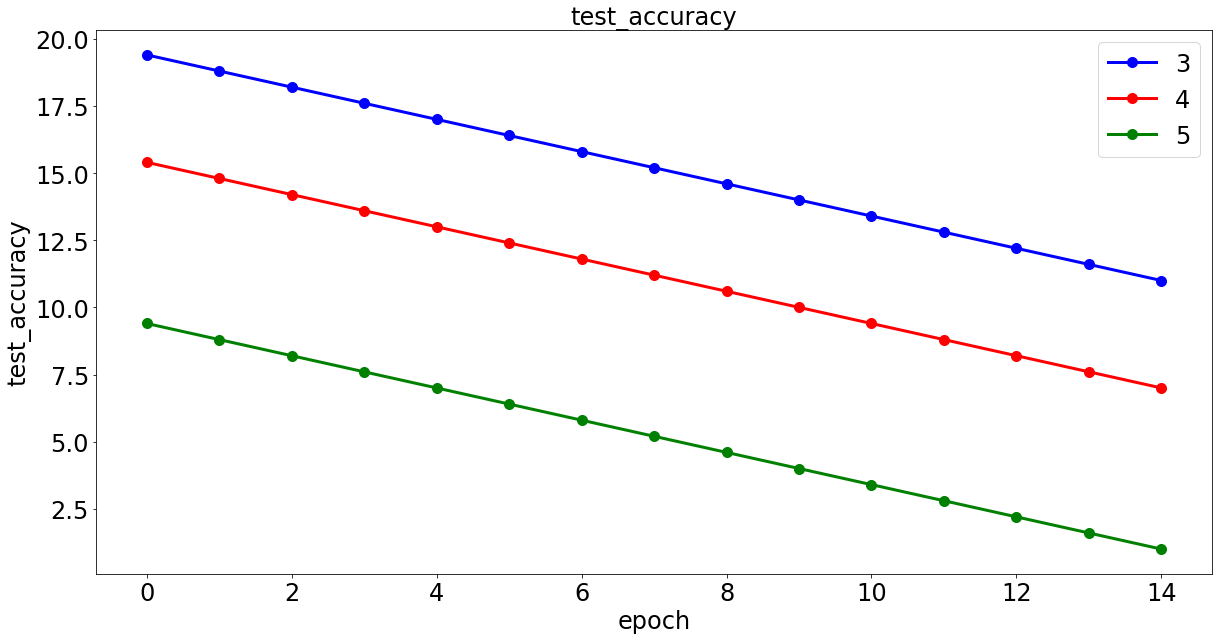

In [12]:
em.experiment_visualization ([3,4,5], backend='matplotlib')